In [44]:
%matplotlib inline

In [45]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

Problem 1.

In [46]:
#squared loss function
def squared_loss(a,b, x, y, dy):
    model_y = a*x + b
    residuals = y - model_y
    return np.sum((residuals/dy) ** 2)

In [47]:
#fitting a line to the full sample
grid_a = np.linspace(0,5,100)
grid_b = np.linspace(-5,5,100)

values = np.zeros((len(grid_a), len(grid_b)))
for i, a in enumerate(grid_a):
    for j, b in enumerate(grid_b):
        values[i,j] = squared_loss(a,b ,x, y, dy)

val_min = np.unravel_index(np.argmin(values), values.shape)
val_min

a_best = grid_a[val_min[0]]
b_best = grid_b[val_min[1]]

print(f"a_best is:", a_best)
print(f"b_best is:", b_best)

a_best is: 2.121212121212121
b_best is: 5.0


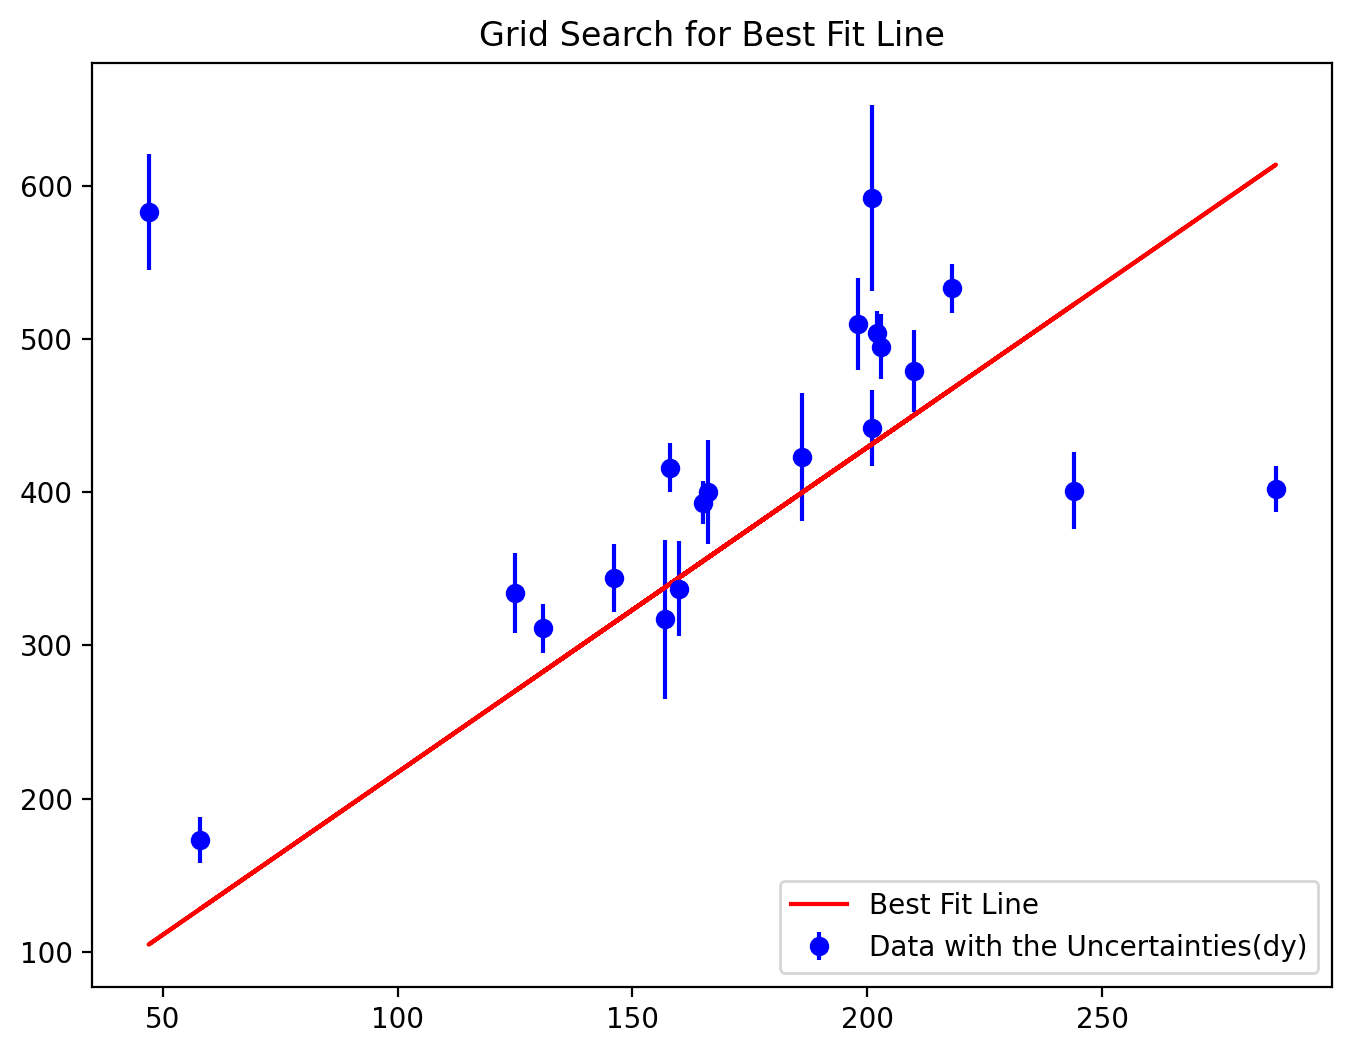

In [48]:
#plot
plt.figure(figsize=(8,6))
plt.errorbar(x,y,yerr=dy,fmt = 'bo', label='Data with the Uncertainties(dy)')
plt.plot(x, a_best*x + b_best, 'r-', label='Best Fit Line')
plt.title("Grid Search for Best Fit Line")
plt.legend(loc='lower right')
plt.show()

In [49]:
residual = y - (a_best*x + b_best)
residual_std = np.std(residual)

#sigmaclipping

sigma = 3.0
mask = np.abs(residual) < sigma * residual_std
clean_x = x[mask]
clean_y = y[mask]
clean_dy = dy[mask]

In [50]:
values_clean = np.zeros((len(grid_a),len(grid_b)))

for i, a in enumerate(grid_a):
    for j, b in enumerate(grid_b):
        values_clean[i,j] = squared_loss(a,b ,clean_x, clean_y, clean_dy)

val_min_clean = np.unravel_index(np.argmin(values_clean), values_clean.shape)

a_best_clean = grid_a[val_min_clean[0]]
b_best_clean = grid_b[val_min_clean[1]]

print(f"a_best is:", a_best_clean)
print(f"b_best is:", b_best_clean)

a_best is: 2.121212121212121
b_best is: 5.0


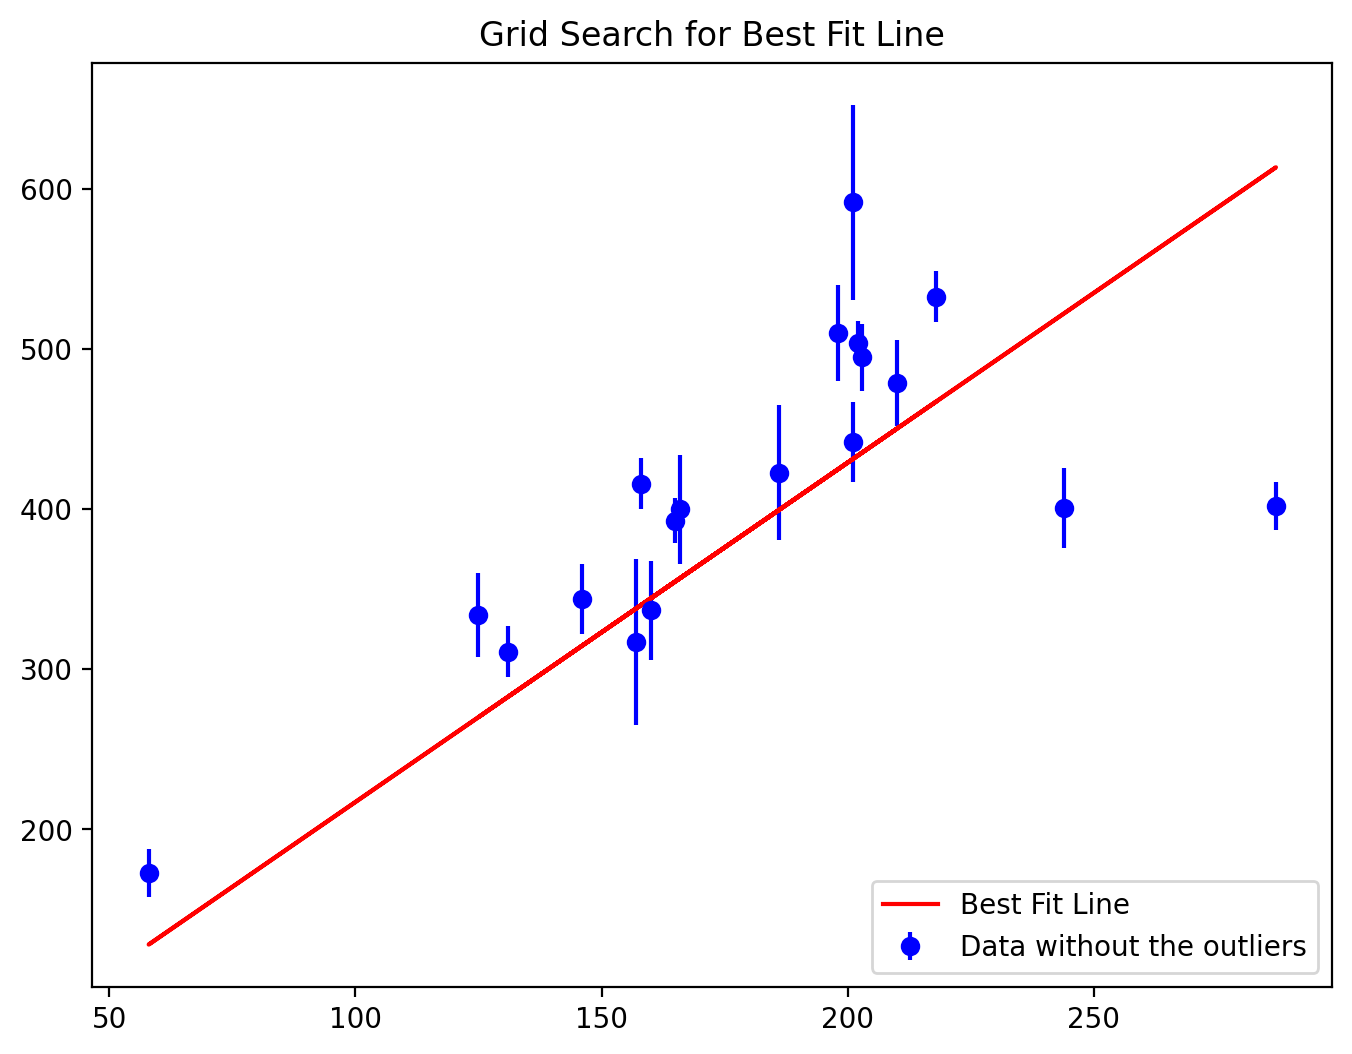

In [51]:
plt.figure(figsize=(8,6))
plt.errorbar(clean_x,clean_y, yerr=clean_dy,fmt = 'bo', label='Data without the outliers')
plt.plot(clean_x, a_best_clean*clean_x + b_best_clean, 'r-', label='Best Fit Line')
plt.title("Grid Search for Best Fit Line")
plt.legend(loc='lower right')
plt.show()

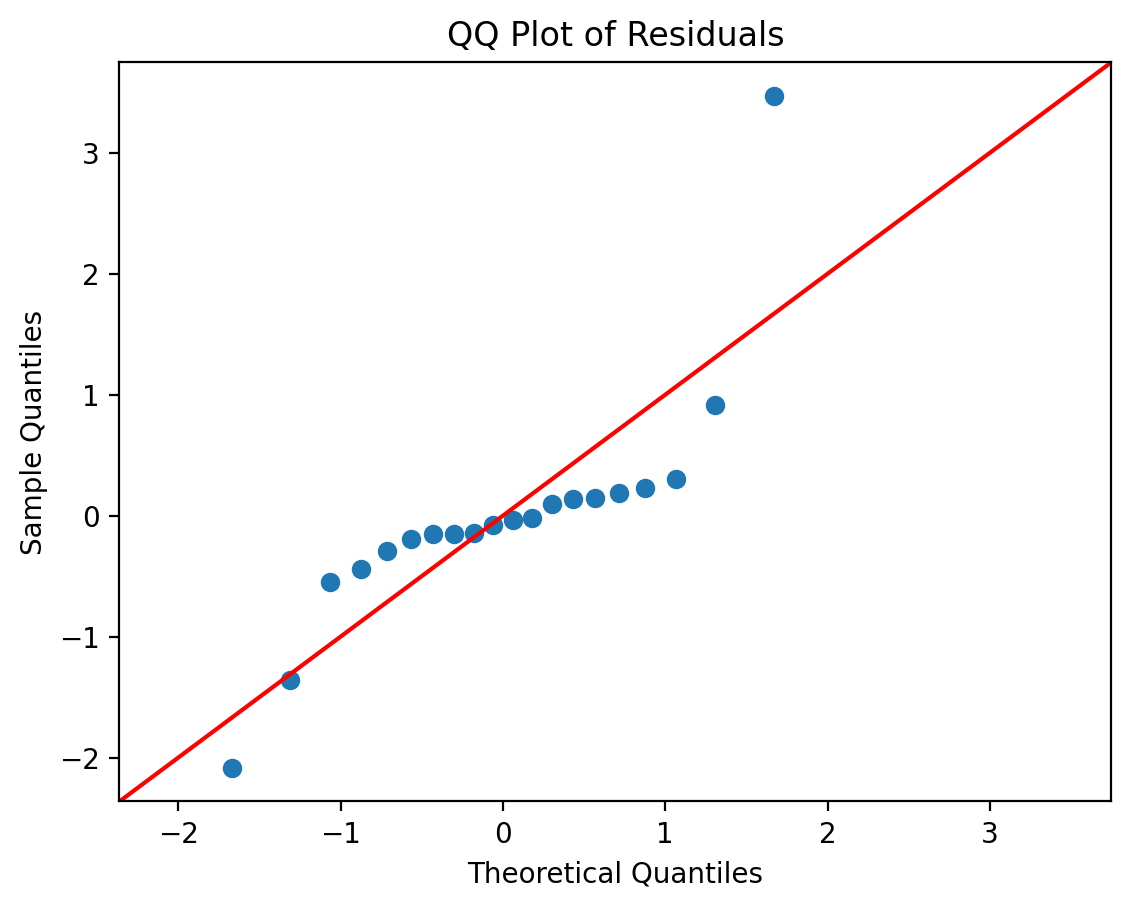

In [52]:
#qqplot
residual2 = clean_y - (a_best_clean*clean_x + b_best_clean)
sm.qqplot(residual, line='45', fit='True')
plt.title("QQ Plot of Residuals")
plt.show()

In [53]:
#robust likelihood function
def robust_likelihood_function(params,x, y,dy):
    a, b = params
    model = a*x + b
    residuals = (y - model)/dy
    return np.sum(np.log(1+0.5 * residuals**2) + np.log(dy))    

In [54]:
from scipy.optimize import minimize
guess = [2.1,5.0]
result_robust_likelihood_function = minimize(robust_likelihood_function, guess, args=(x, y, dy))
robust_a, robust_b = result_robust_likelihood_function.x
print(robust_a)
print(robust_b)
print(x.shape)
print(y.shape)
print(dy.shape)


2.1944416141116485
40.85279911135913
(20,)
(20,)
(20,)


In [55]:
robust_b

np.float64(40.85279911135913)

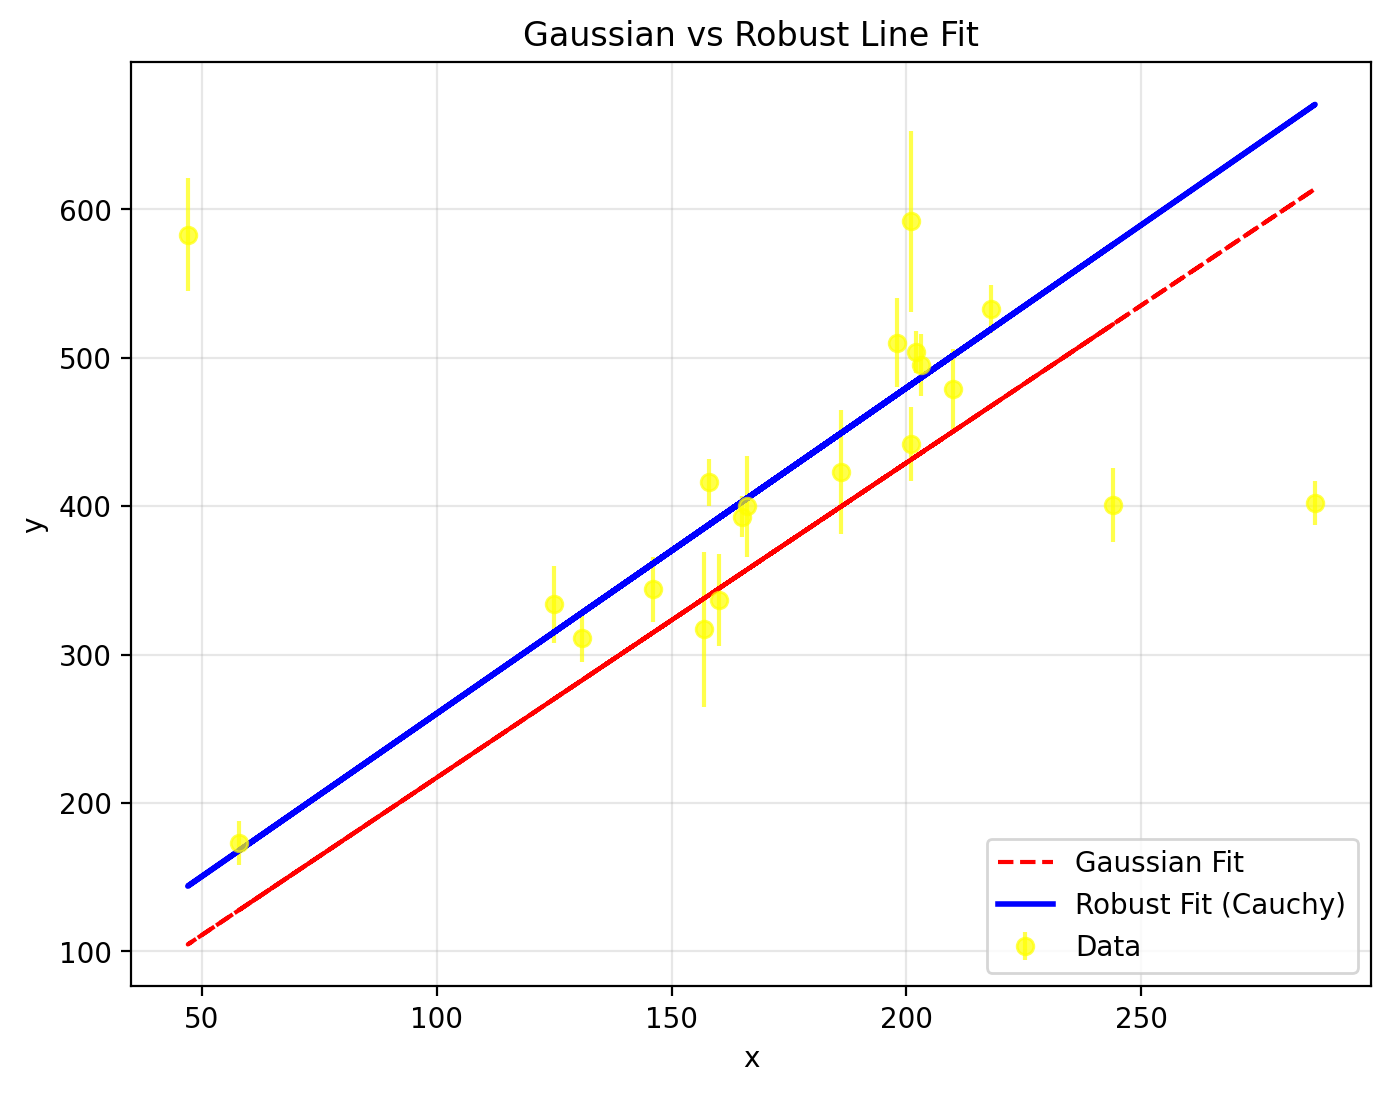

In [56]:

y_gaussian = a_best * x + b_best
y_robust = robust_a* x + robust_b

plt.figure(figsize=(8, 6))

plt.errorbar(x, y, yerr=dy, fmt='o', color='yellow', label='Data', alpha=0.7)

plt.plot(x, y_gaussian, 'r--', label='Gaussian Fit')

plt.plot(x, y_robust, 'b', label='Robust Fit (Cauchy)', linewidth=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian vs Robust Line Fit")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


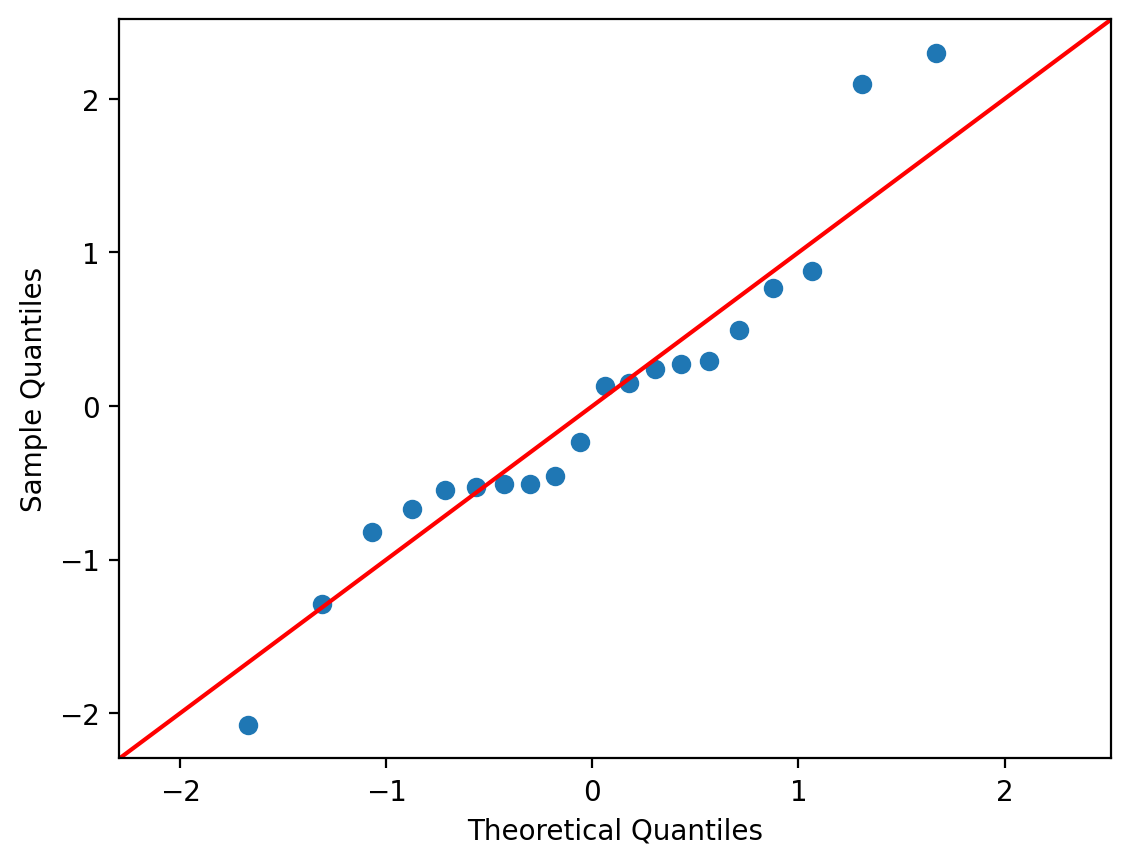

In [98]:
residuals3 = y_gaussian - y_robust
sm.qqplot(residuals3,line="45", fit="True")

Problem 2.

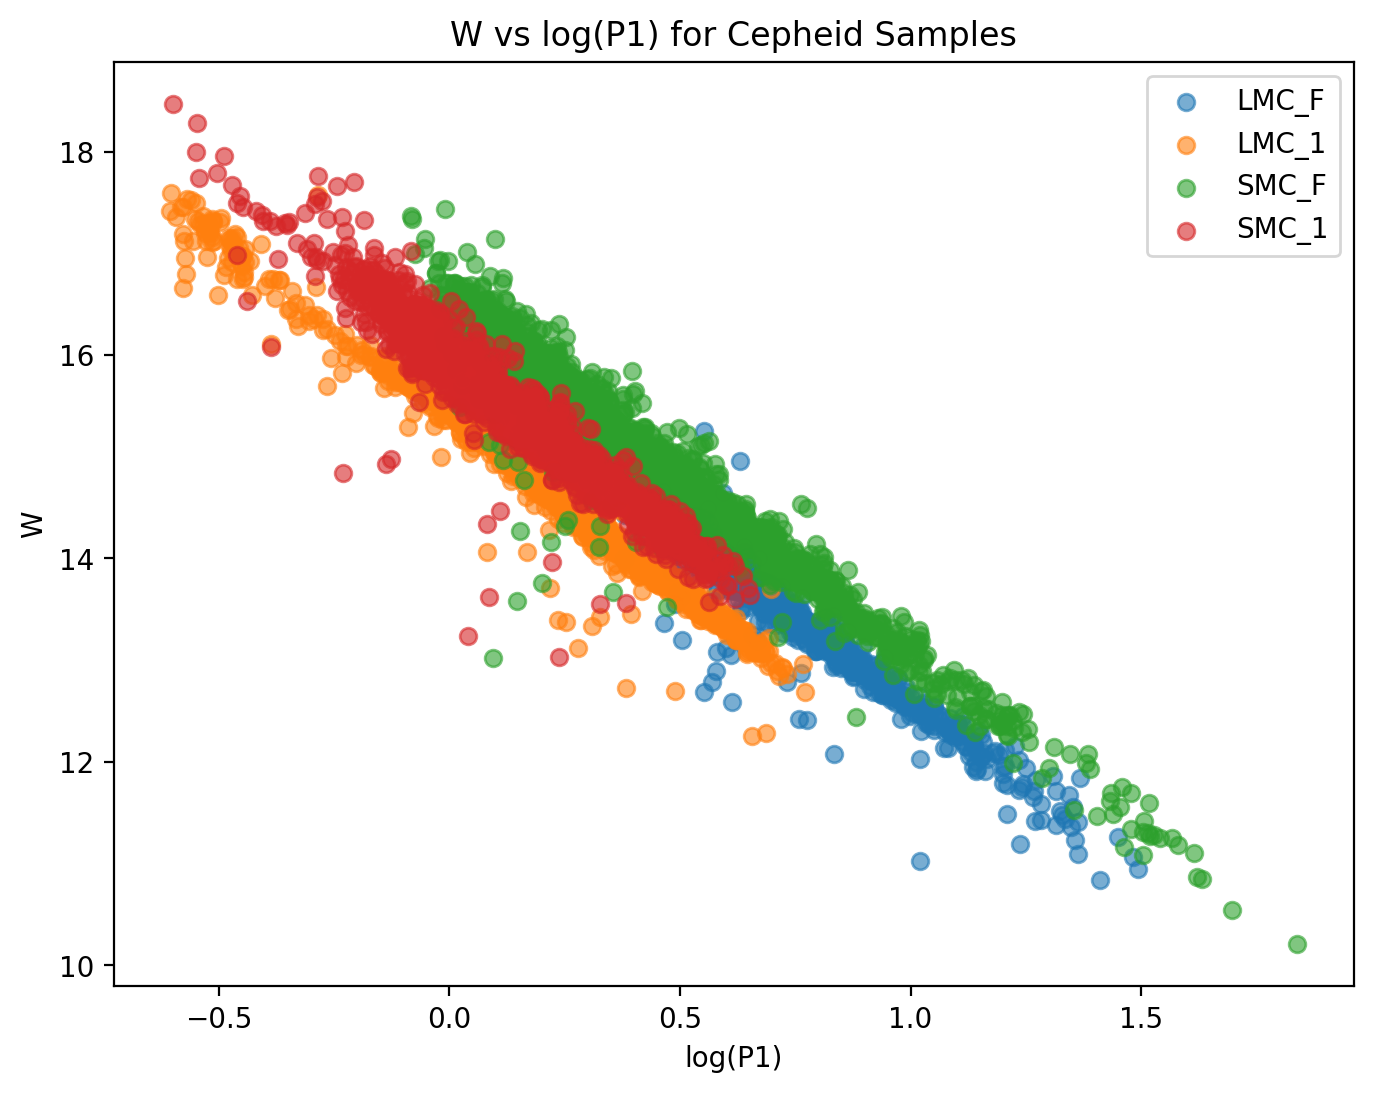

In [118]:
import pandas as pd
df = pd.read_csv(r"C:\Users\shata\Downloads\Cepheids.csv")

df_LMC = data[data['Cloud'] == 'LMC']
df_SMC = data[data['Cloud'] == 'SMC']

def split_by_mode(df):
    return df[df['Mode'] == 'F'], df[df['Mode'] == '1']

LMC_F, LMC_1 = split_by_mode(df_LMC)
SMC_F, SMC_1 = split_by_mode(df_SMC)

def fit_line(x, y):
    a, b = np.polyfit(x, y, 1)
    return a, b

subsets = {
    "LMC_F": LMC_F,
    "LMC_1": LMC_1,
    "SMC_F": SMC_F,
    "SMC_1": SMC_1
}

plt.figure(figsize=(8, 6))
for name, subset in subsets.items():
    plt.scatter(subset['logP1'], subset['W'], label=name, alpha=0.6)
plt.xlabel("log(P1)")
plt.ylabel("W")
plt.legend()
plt.title("W vs log(P1) for Cepheid Samples")
plt.show()


In [109]:
# --- Fit each group and compute residuals ---
for name, subset in subsets.items():
    x = subset['logP1'].values
    y = subset['W'].values
    a, b = fit_line(x, y)
    y_fit = a * x + b
    residuals = y - y_fit
    print(f"{name}: a = {a:.3f}, b = {b:.3f}, mean residual = {residuals.mean():.3f}")


LMC_F: a = -3.326, b = 15.893, mean residual = -0.000
LMC_1: a = -3.432, b = 15.384, mean residual = -0.000
SMC_F: a = -3.454, b = 16.480, mean residual = 0.000
SMC_1: a = -3.615, b = 15.962, mean residual = -0.000


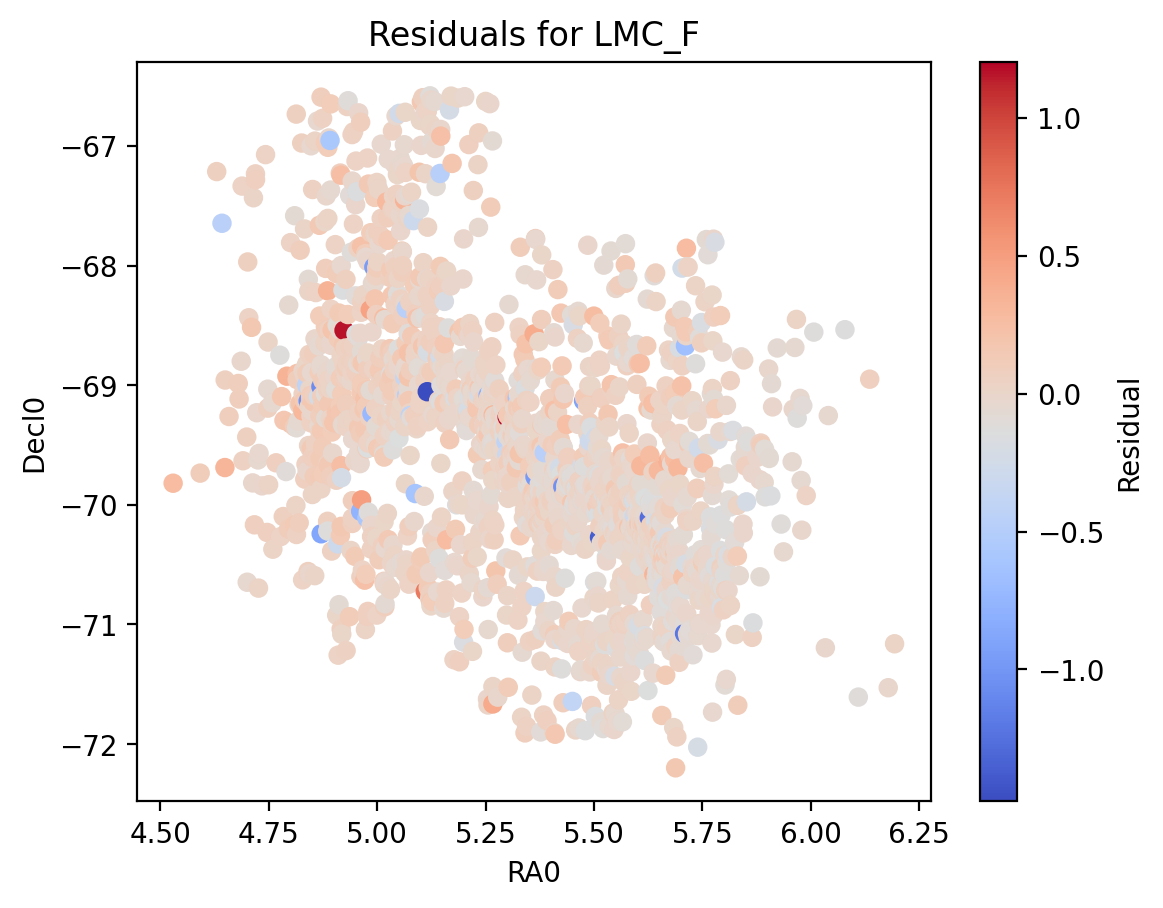

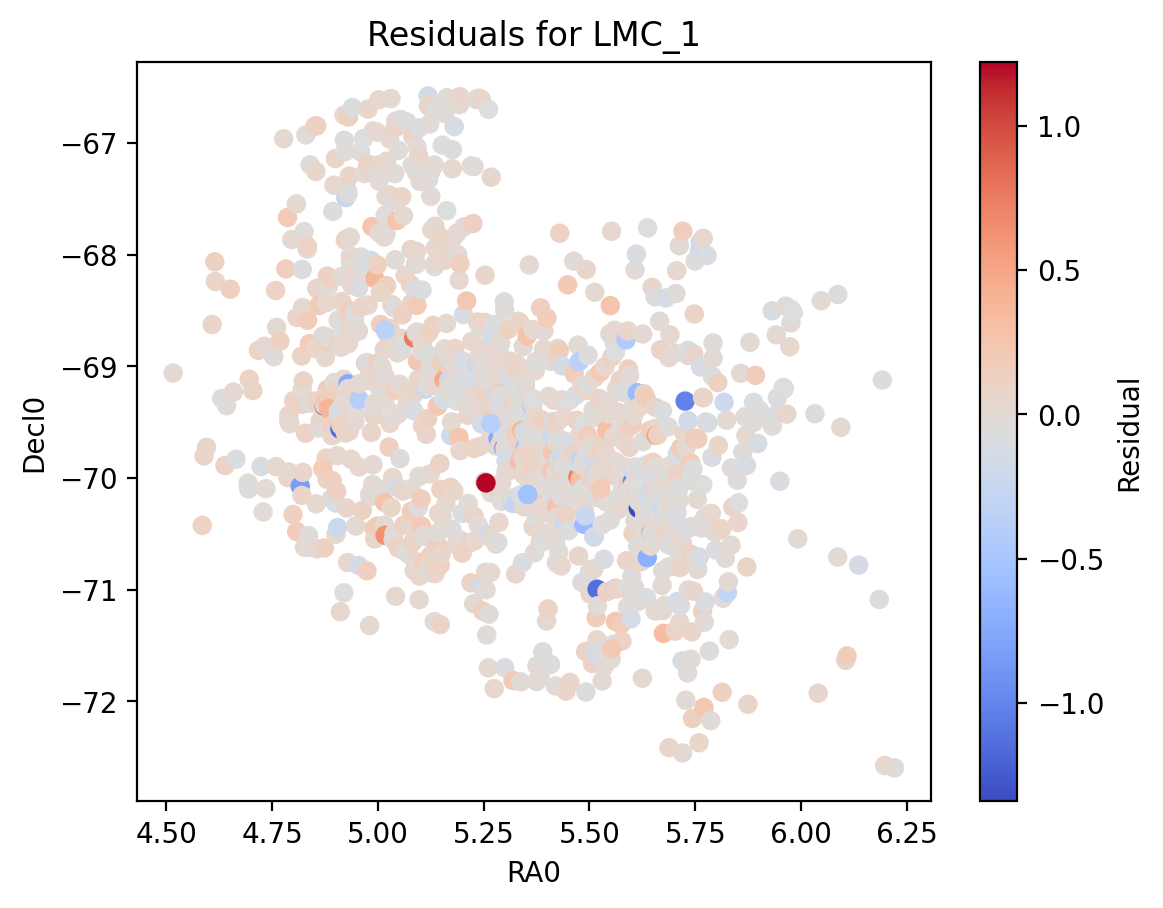

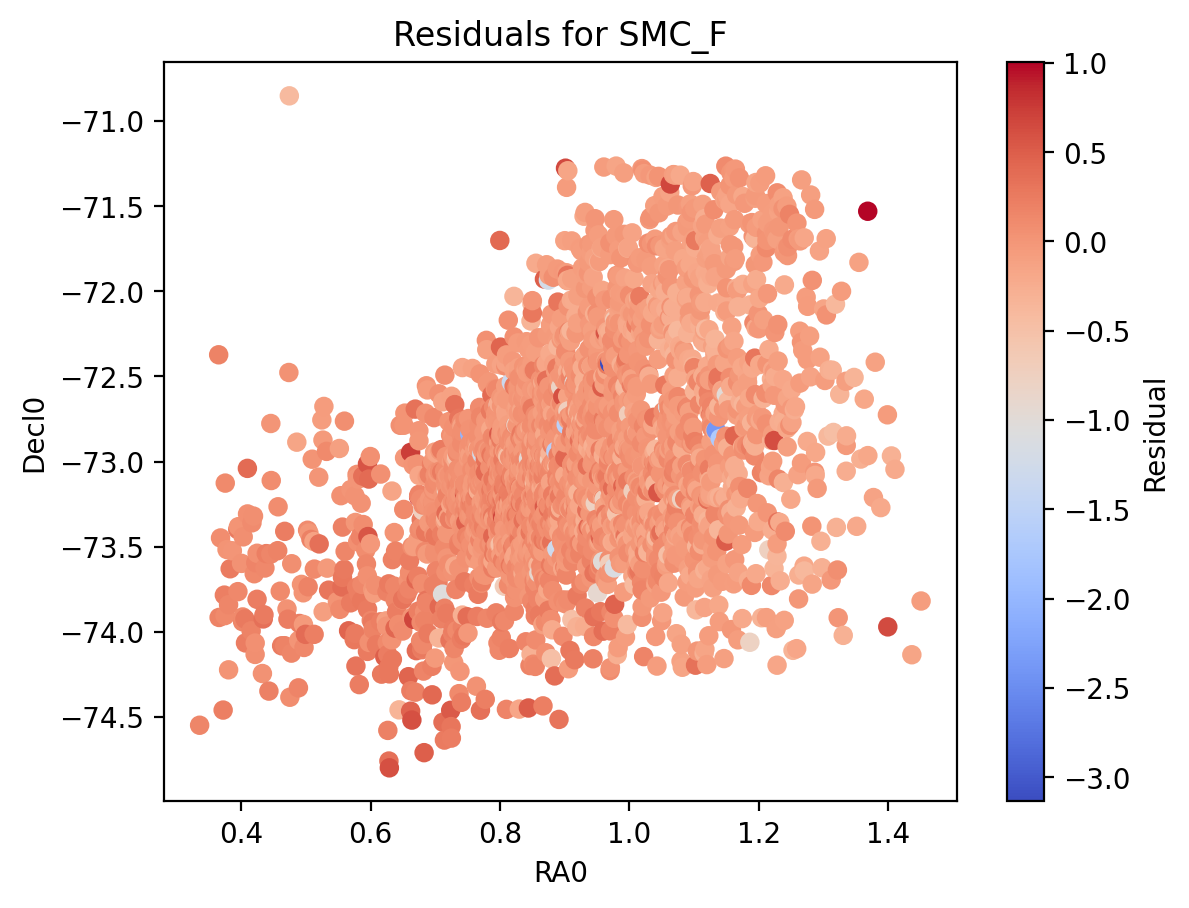

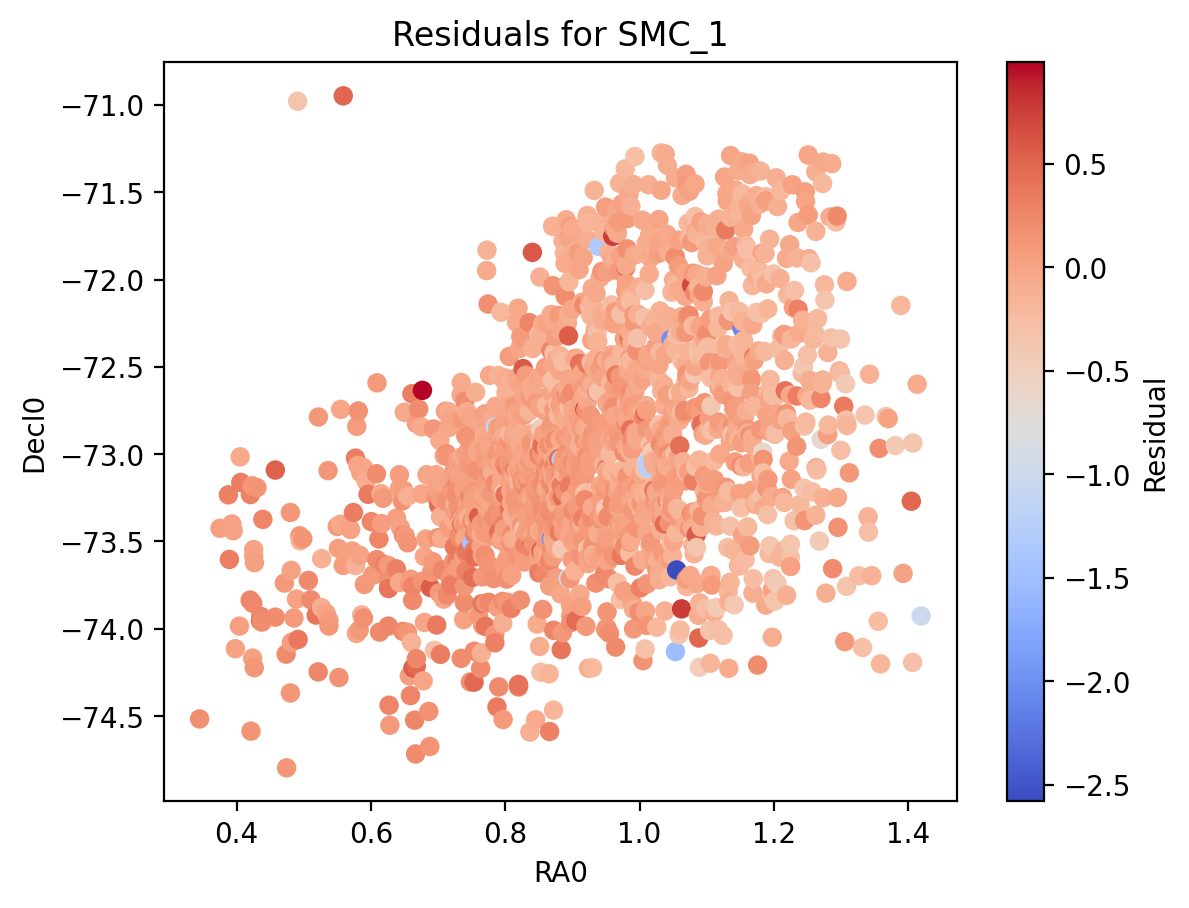

In [116]:
# Plot residuals vs RA, Dec
for name, subset in subsets.items():
    x = subset['logP1'].values
    y = subset['W'].values
    a, b = fit_line(x, y)
    y_fit = a * x + b
    residuals = y - y_fit
    plt.scatter(subset['RA0'], subset['Decl0'], c=residuals, cmap='coolwarm')
    plt.colorbar(label='Residual')
    plt.xlabel("RA0")
    plt.ylabel("Decl0")
    plt.title(f"Residuals for {name}")
    plt.show()

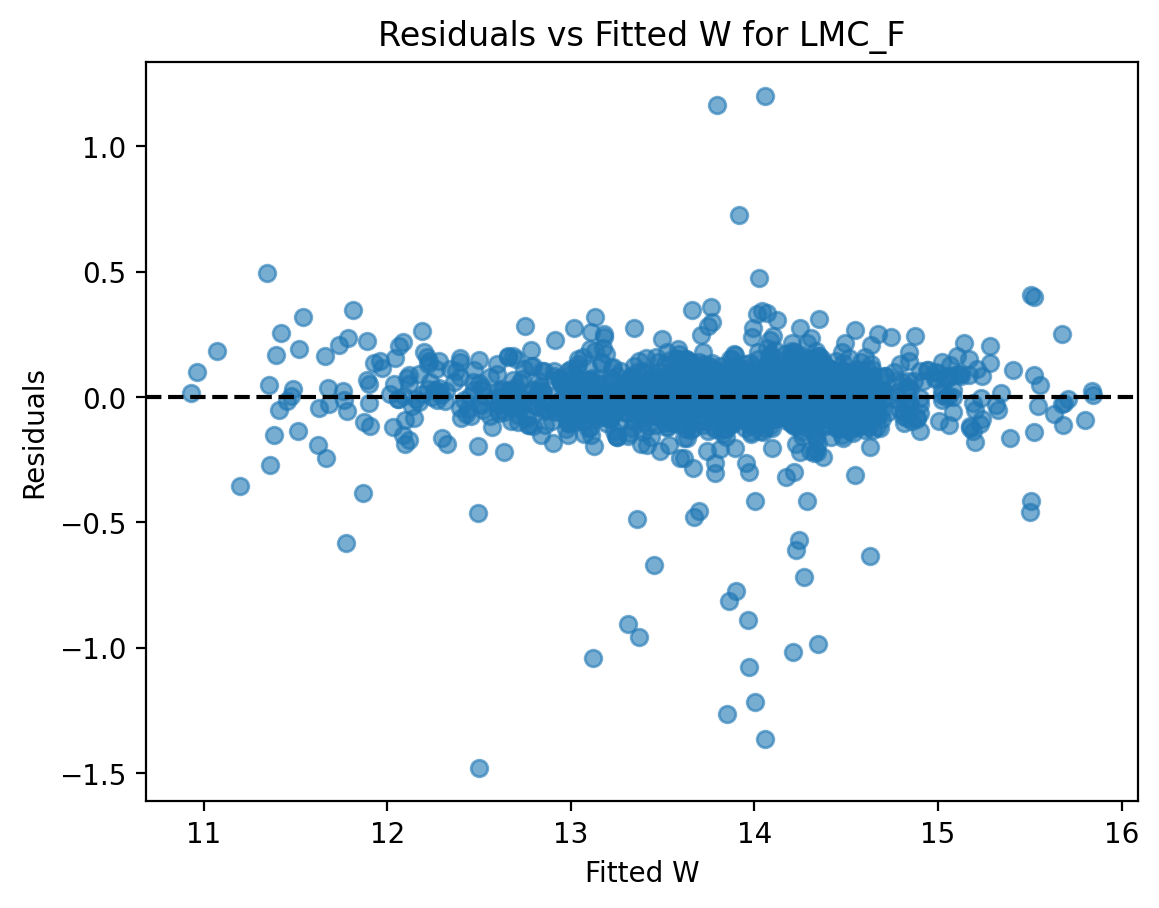

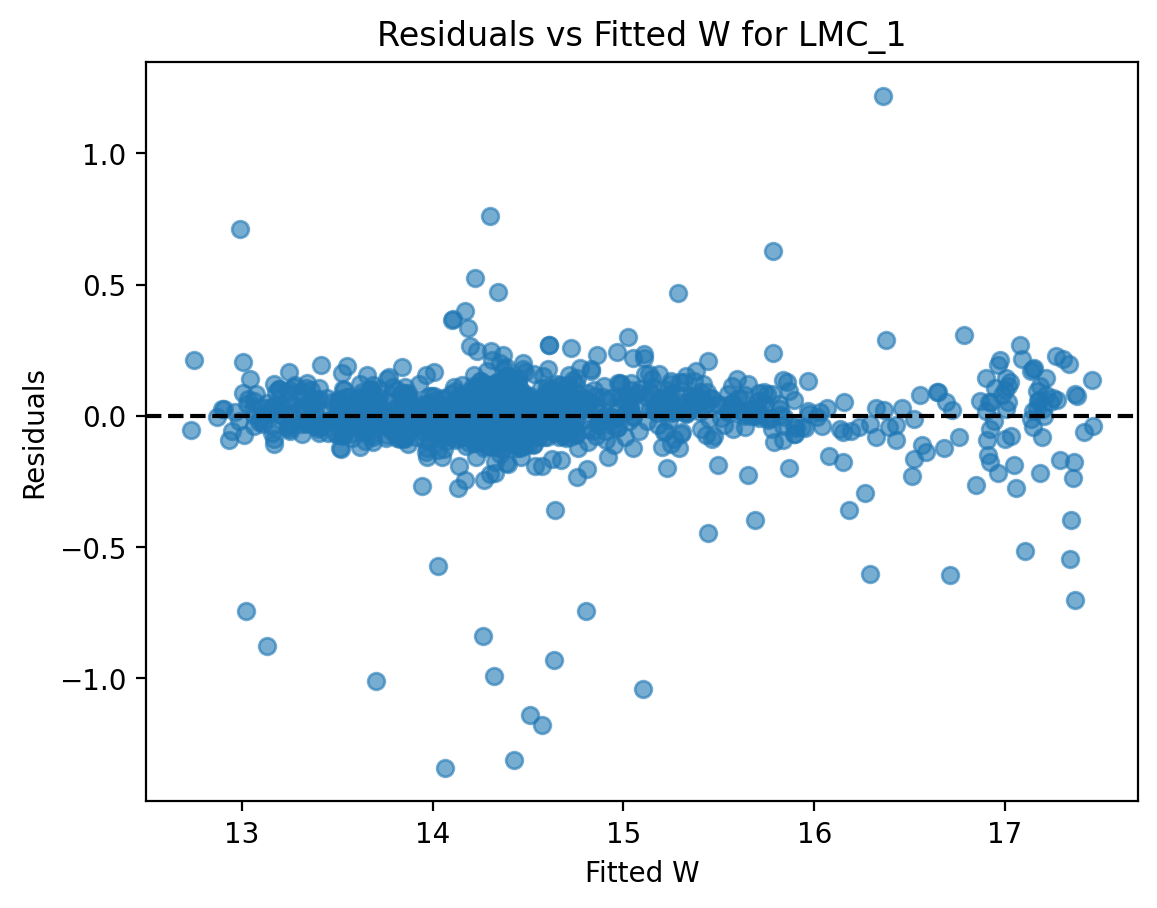

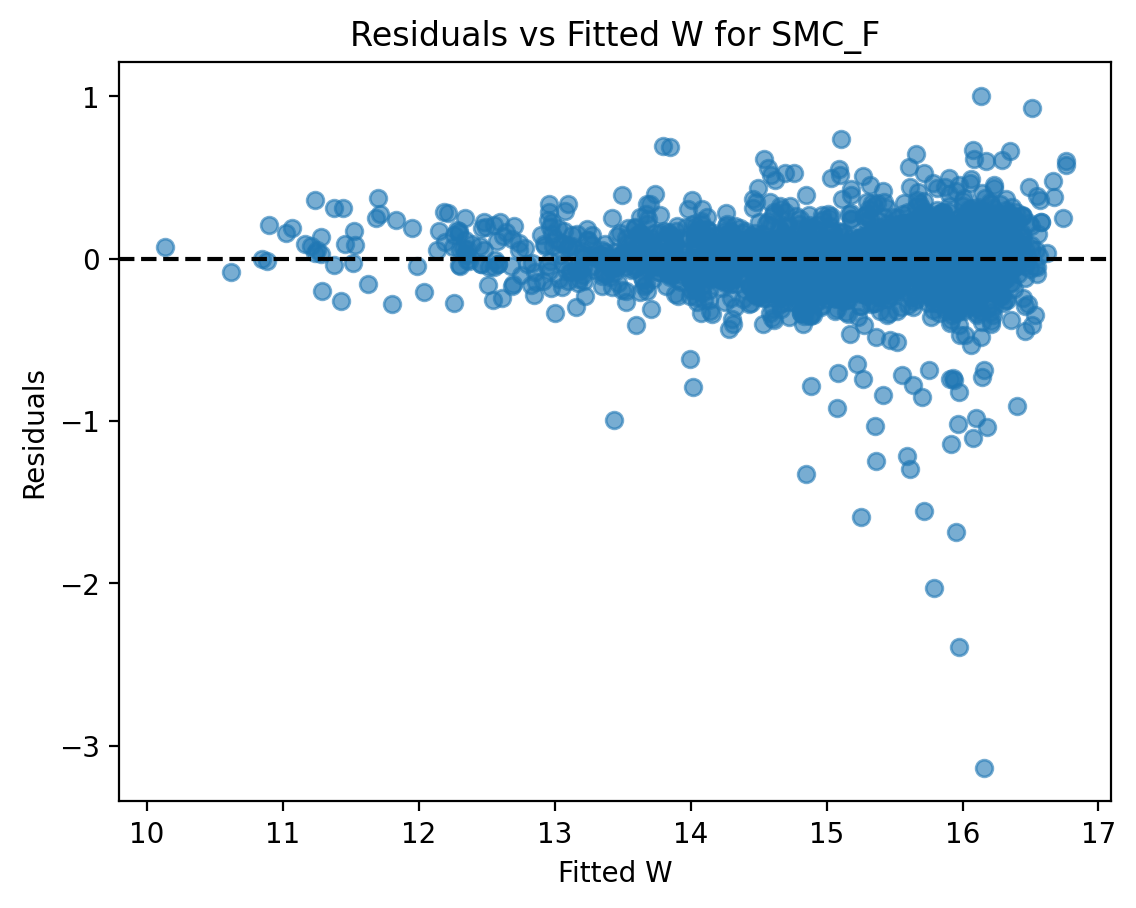

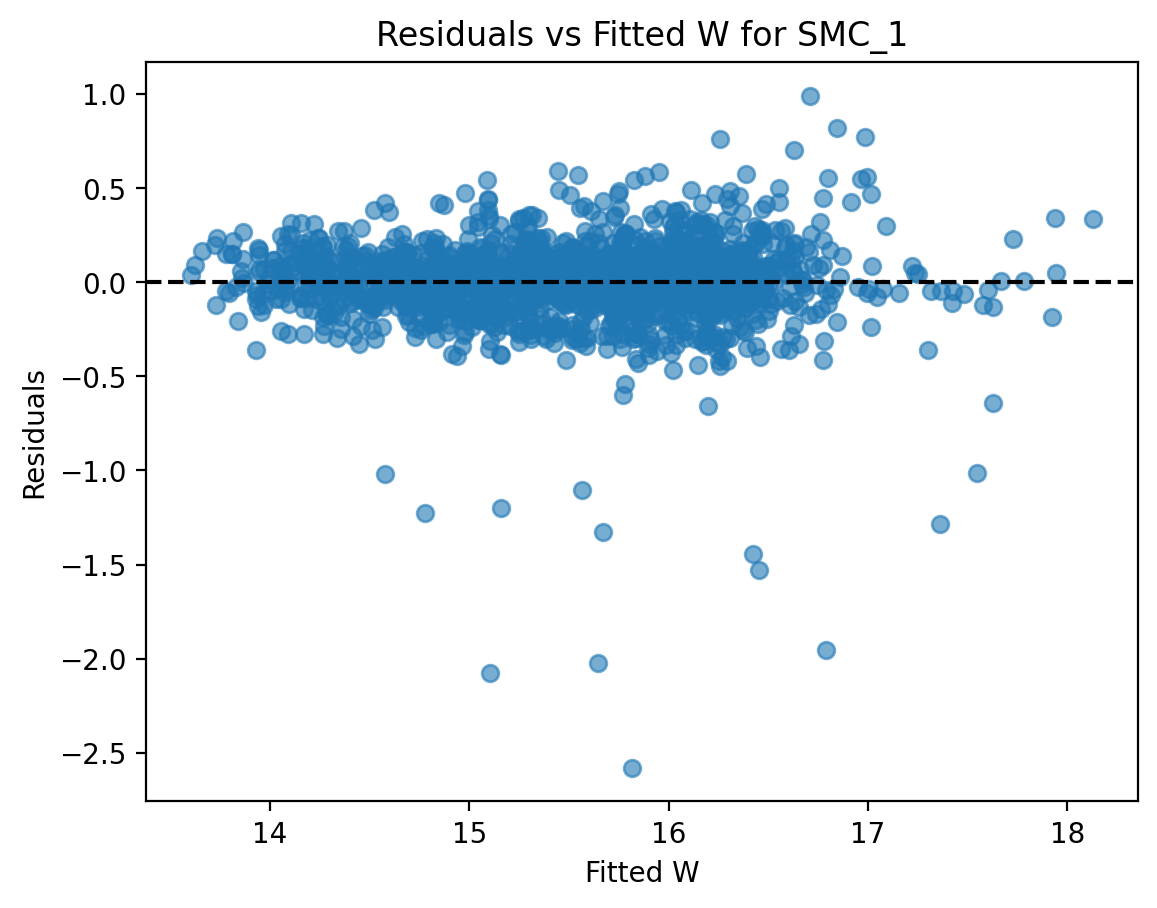

In [117]:
# Plot residuals vs fitted W
for name, subset in subsets.items():
    x = subset['logP1'].values
    y = subset['W'].values
    a, b = fit_line(x, y)
    y_fit = a * x + b
    residuals = y - y_fit
    plt.scatter(y_fit, residuals, alpha=0.6)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Fitted W")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted W for {name}")
    plt.show()
